In [9]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *
from ct_tracking_library.ct_fk_functions import *

#used for GUI
%matplotlib notebook

#find transform
import datetime
import time
import pickle
from spatialmath import *
from roboticstoolbox import ET as E
import transforms3d as t3d
import itertools

In [65]:
def get_marker(selected_series,time,v = False, debug = False):
    """
    This function finds the marker from the user sleceted dicom file:

    Args:
        selected_series(string): the serial key for the slected DICOM.
        time(Time): time intial when the function is called.
        v(bool): to show visualization for the marker
        debug(bool): wheather or not the user want to see debug info.

    Returns:
        M_list[0](Marker): the moveing marker object finded
        M_list[1](Marker): the fixed marker object finded
        v_mesh(Open3d mesh): the mesh used for finding the marker in form of open3d

    """
    M_list = []
    data_directory = "./test_data/DICOM"
    file_reader = sitk.ImageFileReader()
    series_file_names = {}
    series_IDs = list(sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory))
    if series_IDs:
        for series in series_IDs:
            series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    for S in range(2):
        # pick marker
        if S == 0:
            target_marker_name = 'moving_marker_1_DoF'
            marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
            R = np.eye(3)
            crop_z = None
        else:
            target_marker_name = 'fixed_marker_1_DoF'
            marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
            R = np.eye(3)
            crop_z = None

        #convert scan to mesh for finding markers via thresholding
        scan_file = series_file_names[selected_series]
        convert_scan_to_mha(scan_file, crop_z = crop_z)
        convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

        #find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
        _, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=debug)
        if debug:
            print('marker centroid coordinates from design: {}'.format(marker))
            print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

        #display candidate fiducials
        if v:
            o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

        #find best transform and marker from candidate fiducials
        tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

        #get rid of column of ones to make 3xN
        permuted_centroids = permuted_centroids[:3,:].T

        #transform marker geometry coordinates using found transform to tracked image coordinates
        transformed_marker = (tracked_R @ marker.T + tracked_t).T
        error = permuted_centroids-transformed_marker
        
        #tracking error from final transform
        np.set_printoptions(2)
        print("Error (mm): {}".format(error))
        print("Error norm (mm): {}".format(np.linalg.norm(error)))
        if v:
            #create o3d visualizations
            marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
            marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
            marker_3d_base.append(create_coordinate_frame_visualization())
            marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
            marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))
            #visualize tracked markers on top of mesh used for tracking
            visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
            visualization_list1 = copy.deepcopy(visualization_list2)
            o3d.visualization.draw_geometries(visualization_list2)
        if S == 0:
            v_mesh= marker_mesh
        #append marker
        print("T find: ",tracked_t)
        M_list.append(Marker(name=target_marker_name,d_key=selected_series,time =time,geometry=marker,T=SE3(t2T(tracked_R, tracked_t)),error=np.linalg.norm(error, axis=1)))
        
    return M_list[0],M_list[1],v_mesh

In [66]:
def plot3l(x_l,y_l,z_l,R):
    plt.figure()
    plt.plot(range(len(x_l)),x_l,linestyle='--', marker='o')
    plt.plot(range(len(y_l)),y_l,linestyle='--', marker='o')
    plt.plot(range(len(z_l)),z_l,linestyle='--', marker='o')
    plt.xlabel("Scan #")
    if R == True:
        plt.ylabel("Euler Angle Degree")
        plt.title("Scan # Vs. Degree")
        plt.legend(['r', 'θ','Φ'])
    else:
        plt.ylabel("Distance(mm)")
        plt.title("Scan # Vs. Distance")
        plt.legend(['X', 'Y','Z'])
    plt.show()

In [67]:
with open('./test_data/data_ol.pkl', 'rb') as f:
    new_data2 = pickle.load(f)

In [13]:
with open('./test_data/data.pkl', 'rb') as f:
    new_data = pickle.load(f)

In [14]:
u_list = [0,25,50,75]
key_list = ['1.2.840.113619.2.416.6795503943617817801219389912763296544',
           '1.2.840.113619.2.416.6091776499222851246423953174468199664',
           '1.2.840.113619.2.416.100083941475652116358255918161510130375',
           '1.2.840.113619.2.416.61935088023485344866325542289366845877']
ratio = 0.5040628051757813 #converting mm to rev

In [63]:
u_list = [0,25,25]
key_list = ['1.2.840.113619.2.416.62822073684450593006915679259050948385',
           '1.2.840.113619.2.416.19572949673884394948003370560242135657',
           '1.2.840.113619.2.416.71661528754400335967875173428732748884']
ratio = 0.5040628051757813 #converting mm to rev

## Created new_data

In [64]:
new_data = {}
mesh_l=[]
for x in range(len(u_list)):
    selected_keys = key_list[x]
    name = 'scan'+str(x)
    marker1,marker2,mesh = get_marker(selected_keys,new_data3[name][0].time)
    mesh_l.append(mesh)
    robot = new_data3[name][2]
    append_value(new_data, "scan"+str(x), marker1)
    append_value(new_data, "scan"+str(x), marker2)
    append_value(new_data, "scan"+str(x), robot)

NameError: name 'new_data3' is not defined

In [17]:
offset = (SE3(new_data['scan0'][1].T).inv()*SE3(new_data['scan0'][0].T)).t[2]
ds = input("Enter the desried postion: ")
marker1 = new_data['scan1'][0]
marker2 = new_data['scan1'][1]
m1t = SE3(marker1.T)
Dersied = copy.deepcopy(m1t)
Dersied.t[0] = m1t.t[0]+np.sign(m1t.t[0])*(int(ds))
peval = abs(Dersied.t[0])-abs(SE3(marker1.T).t[0])
fk,r_error,p_error = find_fk(marker1,marker2,robot,peval)

KeyError: 'scan0'

In [18]:
display_fk(fk,marker1,mesh_l[1])

NameError: name 'fk' is not defined

## Plots

In [19]:
ee_list = []
b_list = []
for y in new_data:
    ee_list.append(new_data[y][0].error)
    b_list.append(new_data[y][1].error)
sns.boxplot(data=ee_list,  orient='v').set(title='Fiducial Error for End Effector Marker',ylabel="distance(mm)",xlabel="Scan#")
plt.figure()
sns.boxplot(data=b_list,  orient='v').set(title='Fiducial Error for Base Marker',ylabel="distance(mm)",xlabel="Scan#")

IndexError: list index out of range

In [20]:
marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
R = np.eye(3)
visualization_list = [mesh]
color = [.8, .6, .8]
for x in new_data:
    print(x)
    marker_3d_tracked = create_marker_visualization(marker, color, SE3(new_data[x][1].T).R, SE3(new_data[x][1].T).t.reshape((3,1))) #blue color
    visualization_list += marker_3d_tracked
    color = [y-.2 for y in color]
o3d.visualization.draw_geometries(visualization_list)

TypeError: draw_geometries(): incompatible function arguments. The following argument types are supported:
    1. (geometry_list: List[open3d.cpu.pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False) -> None
    2. (geometry_list: List[open3d.cpu.pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False, lookat: numpy.ndarray[numpy.float64[3, 1]], up: numpy.ndarray[numpy.float64[3, 1]], front: numpy.ndarray[numpy.float64[3, 1]], zoom: float) -> None

Invoked with: [<module 'stl.mesh' from 'C:\\Users\\snowl\\anaconda3\\lib\\site-packages\\stl\\mesh.py'>]

In [21]:
pn = calc_p_error(SE3(new_data['scan1'][1].T).t,SE3(new_data['scan0'][1].T).t)
rn = calc_needle_ori_error(SE3(new_data['scan1'][1].T).R,SE3(new_data['scan0'][1].T).R)
for x in dict(itertools.islice(new_data.items(), 2,4)):
    pn = np.hstack((pn,calc_p_error(SE3(new_data[x][1].T).t,SE3(new_data['scan0'][1].T).t)))
    rn = np.vstack((rn,calc_needle_ori_error(SE3(new_data[x][1].T).R,SE3(new_data['scan0'][1].T).R)))
pnn = np.linalg.norm(pn, axis=0)
rnn = np.linalg.norm(rn, axis=0)
plt.figure()
plt.scatter(range(len(rnn)),rnn)
plt.figure()
plt.scatter(range(len(pnn)),pnn)

KeyError: 'scan1'

### Tsb Base Verfied Plot

In [22]:
x_l = []
y_l = []
z_l = []
x_r = []
y_r = []
z_r = []
for x in new_data:
    pos = SE3(new_data[x][1].T).t
    ros = R2E(SE3(new_data[x][1].T).R)
    x_l.append(pos[0])
    y_l.append(pos[1])
    z_l.append(pos[2])
    x_r.append(ros[0])
    y_r.append(ros[1])
    z_r.append(ros[2])
#plot3l(x_l,y_l,z_l,False)
#plot3l(x_r,y_r,z_r,True)

### Tb EE Verfied Plot

<IPython.core.display.Javascript object>


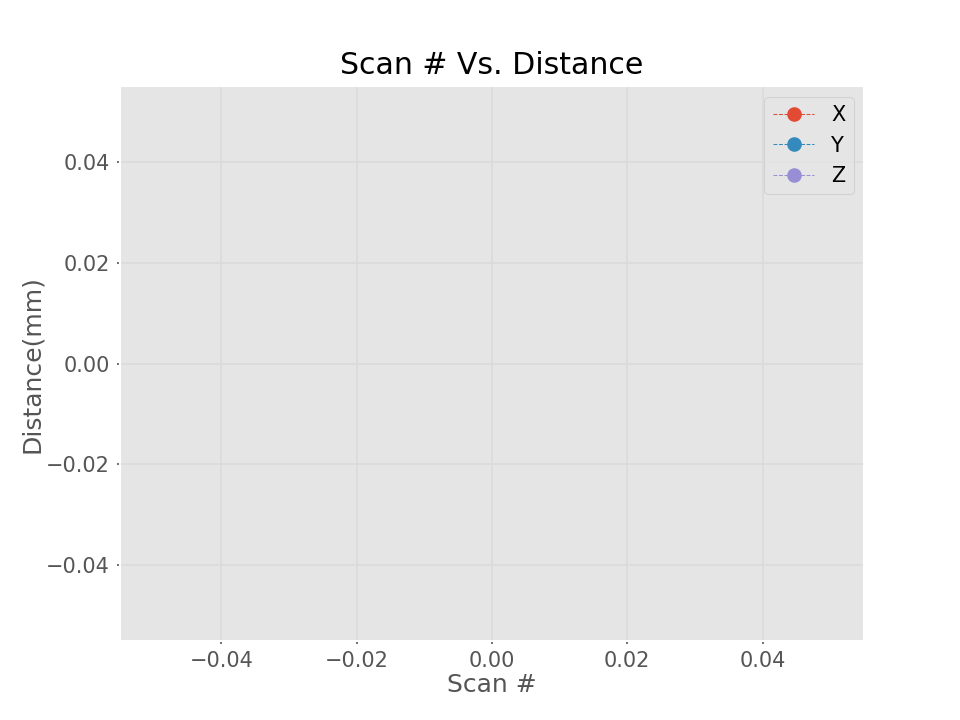

<IPython.core.display.Javascript object>


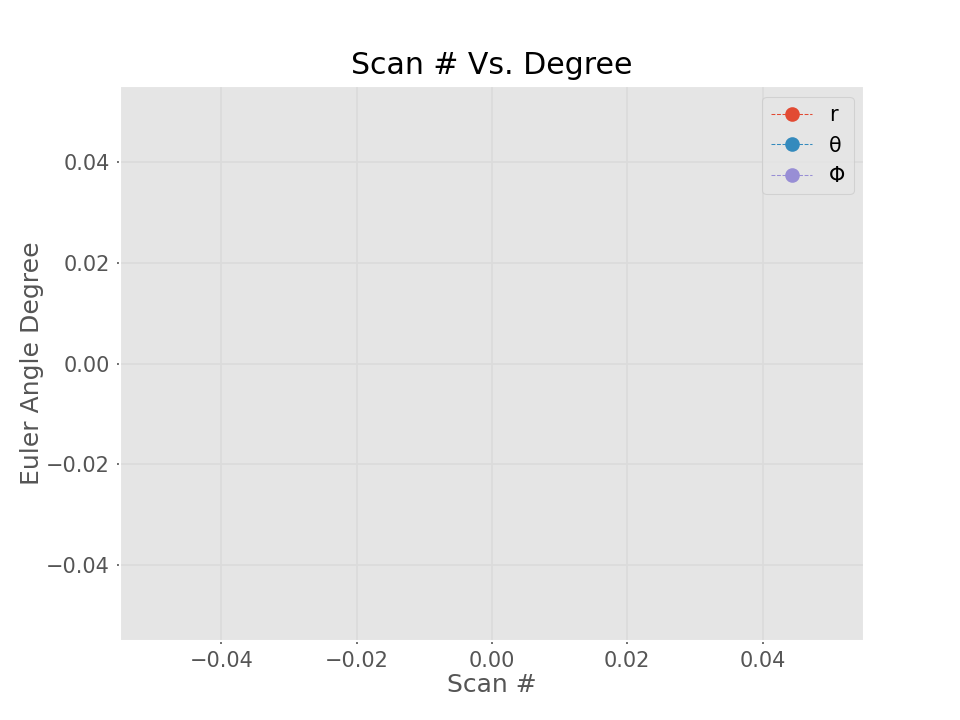

In [23]:
x_l = []
y_l = []
z_l = []
x_r = []
y_r = []
z_r = []
for x in new_data:
    Tbase = SE3(new_data[x][1].T)
    Tee = SE3(new_data[x][0].T)
    Tfinal = Tbase.inv()*Tee
    pos = Tfinal.t
    ros = R2E(Tfinal.R)
    x_l.append(pos[0])
    y_l.append(pos[1])
    z_l.append(pos[2])
    x_r.append(ros[0])
    y_r.append(ros[1])
    z_r.append(ros[2])
plot3l(x_l,y_l,z_l,False)
plot3l(x_r,y_r,z_r,True)

### TFK Verfied Plot

<IPython.core.display.Javascript object>


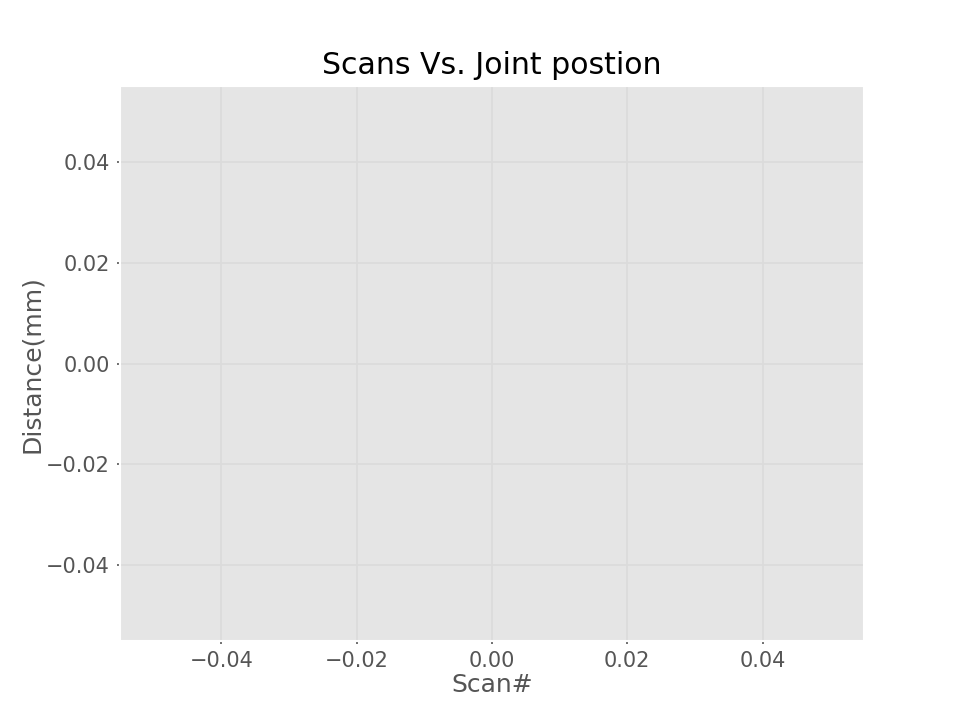

<IPython.core.display.Javascript object>


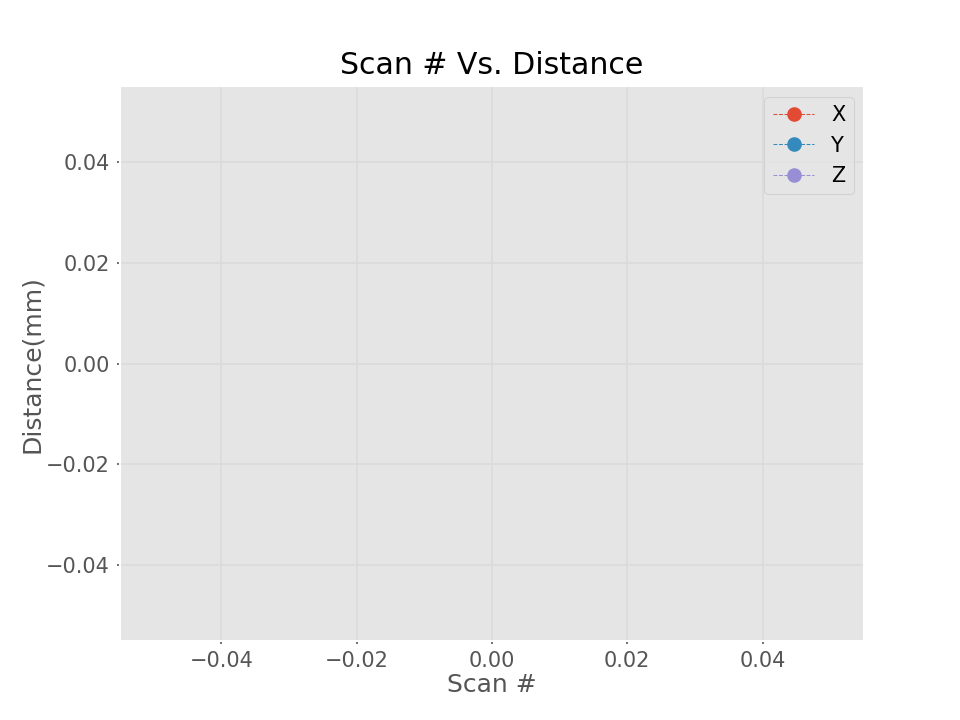

<IPython.core.display.Javascript object>


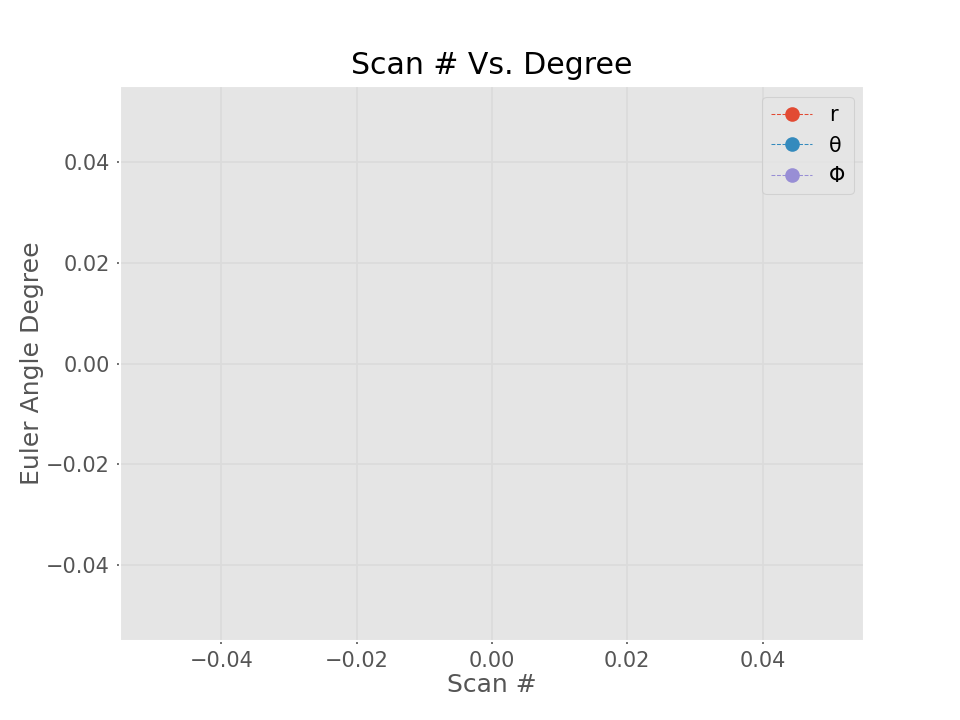

In [24]:
x_l2 = []
y_l2 = []
z_l2 = []
x_r2 = []
y_r2 = []
z_r2 = []
j_l = []
P_norm_list = []
P_list = []
P_std = []
for x in new_data:
    j_l.append(new_data[x][2].joint_postion)
    offset = (SE3(new_data[x][0].T).inv()*SE3(new_data[x][1].T)).t[2]
    ds = input("Enter the desried postion: ")
    m1t = SE3(new_data[x][0].T)
    Dersied = copy.deepcopy(m1t)
    Dersied.t[0] = m1t.t[0]+np.sign(m1t.t[0])*(int(ds))
    peval = abs(Dersied.t[0])-abs(SE3(new_data[x][0].T).t[0])
    fk,r_error,p_error = find_fk(marker1,marker2,new_data[x][2],peval)
    #fk,r_error,p_error = find_fk(new_data[x][0],new_data[x][1],new_data[x][2])
    P_std.append(np.std(p_error))
    P_norm_list.append(np.linalg.norm(p_error))
    P_list.append(p_error)
    pos = (SE3(new_data[x][1].T).inv()*fk).t
    ros = R2E(fk.R)
    x_l2.append(pos[0])
    y_l2.append(pos[1])
    z_l2.append(pos[2])
    x_r2.append(ros[0])
    y_r2.append(ros[1])
    z_r2.append(ros[2])
plt.figure()
plt.plot(j_l,linestyle='--', marker='o')
plt.xlabel("Scan#")
plt.ylabel("Distance(mm)")
plt.title("Scans Vs. Joint postion")
plt.show()
plot3l(x_l2,y_l2,z_l2,False)
plot3l(x_r2,y_r2,z_r2,True)

In [25]:
final_pel = np.hstack((P_list[0],P_list[1]))
for x in P_list[2:]:
    final_pel = np.hstack((final_pel,x))
plot_pe(final_pel)

IndexError: list index out of range

In [26]:
plot_pe(pe_data)

NameError: name 'plot_pe' is not defined

In [27]:
def plot6l(x_l,y_l,z_l,x_l2,y_l2,z_l2,R):
    fg = plt.figure()
    ax = fg.gca()
    y = range(len(x_l))
    ax.plot(y,x_l,linestyle='--', marker='o')
    ax.plot(y,y_l,linestyle='--', marker='o')
    ax.plot(y,z_l,linestyle='--', marker='o')
    ax.plot(y,x_l2,linestyle='--', marker='o')
    ax.plot(y,y_l2,linestyle='--', marker='o')
    ax.plot(y,z_l2,linestyle='--', marker='o')
    ax.xaxis.get_major_locator().set_params(integer=True)
    ax.set_xlabel("Scan #")
    if R == True:
        ax.set_ylabel("Euler Angle Degree")
        ax.set_title("Scan # Vs. Degree")
        ax.legend(['Tracked r', 'Tracked θ','Tracked Φ','Predicted r', 'Predicted θ','Predicted Φ'])
    else:
        ax.set_ylabel("Distance(mm)")
        ax.set_title("Scan # Vs. Distance")
        ax.legend(['Tracked X', 'Tracked Y','Tracked Z','Predicted X', 'Predicted Y','Predicted Z'])
    plt.show()

In [28]:
def plot_pe(final_pel):
    fg = plt.figure()
    ax = fg.gca()
    ax.plot(final_pel[0],linestyle='--', marker='o')
    ax.plot(final_pel[1],linestyle='--', marker='o')
    ax.plot(final_pel[2],linestyle='--', marker='o')
    ax.plot(np.linalg.norm(final_pel,axis=0),linestyle='--', marker='o')
    ax.xaxis.get_major_locator().set_params(integer=True)
    ax.legend(['X', 'Y','Z','Norm'])
    ax.set_ylabel("Position Error(mm)")
    ax.set_title("Scan # Vs. Position Error")
    ax.set_xlabel("Scan #")
    plt.show()

In [29]:
with open('./test_data/Postion.pkl', 'rb') as f:
    pe_data = pickle.load(f)

In [30]:
with open('./test_data/data.pkl', 'rb') as f:
    new_data = pickle.load(f)

<IPython.core.display.Javascript object>


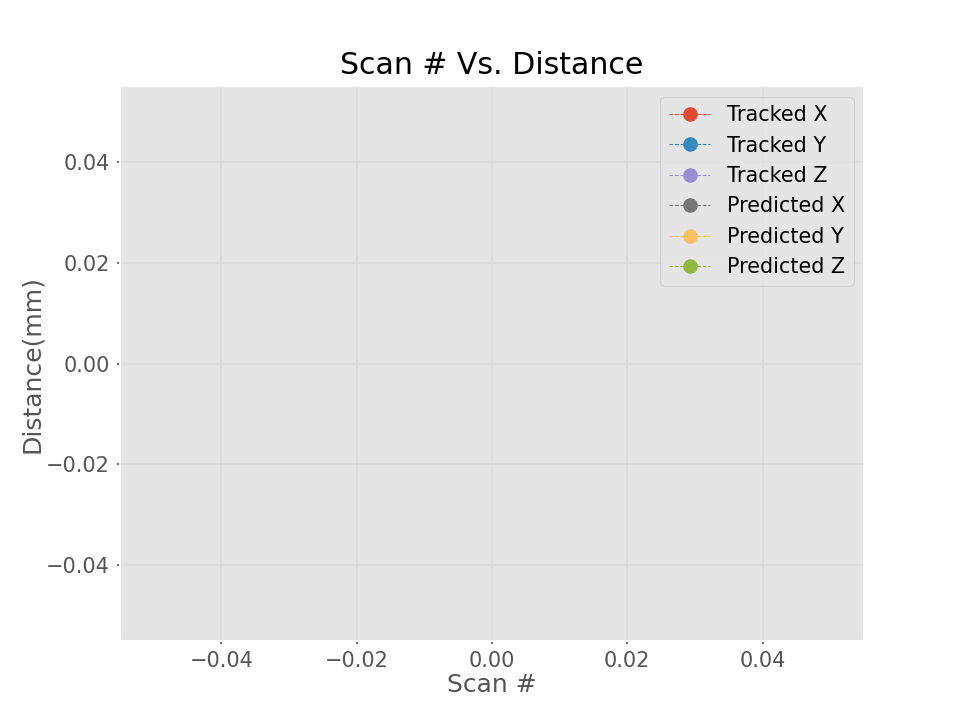

<IPython.core.display.Javascript object>


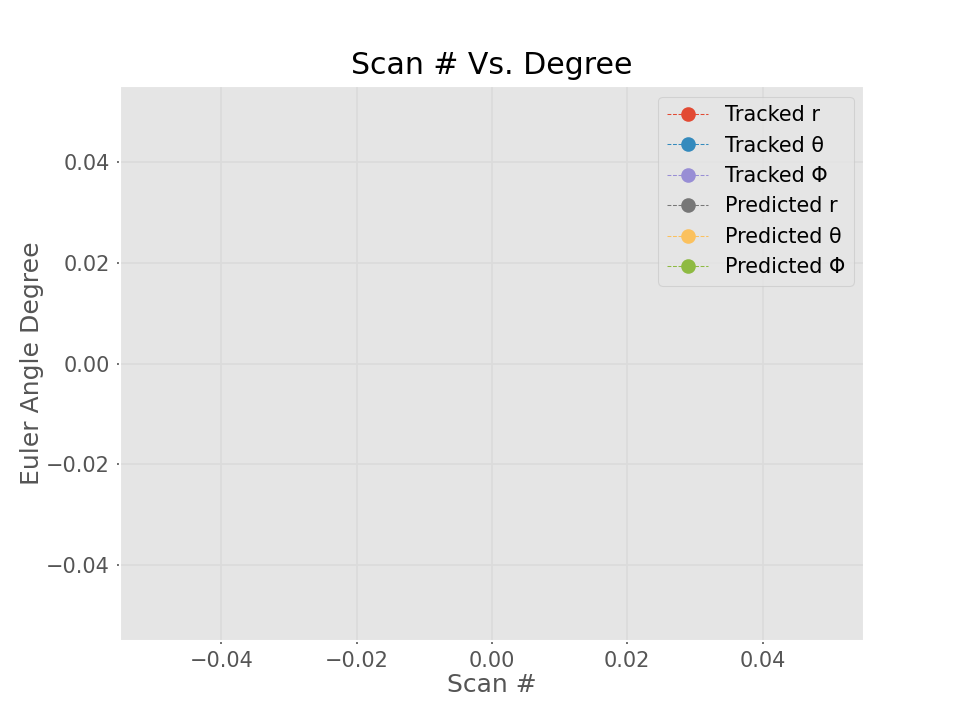

<IPython.core.display.Javascript object>


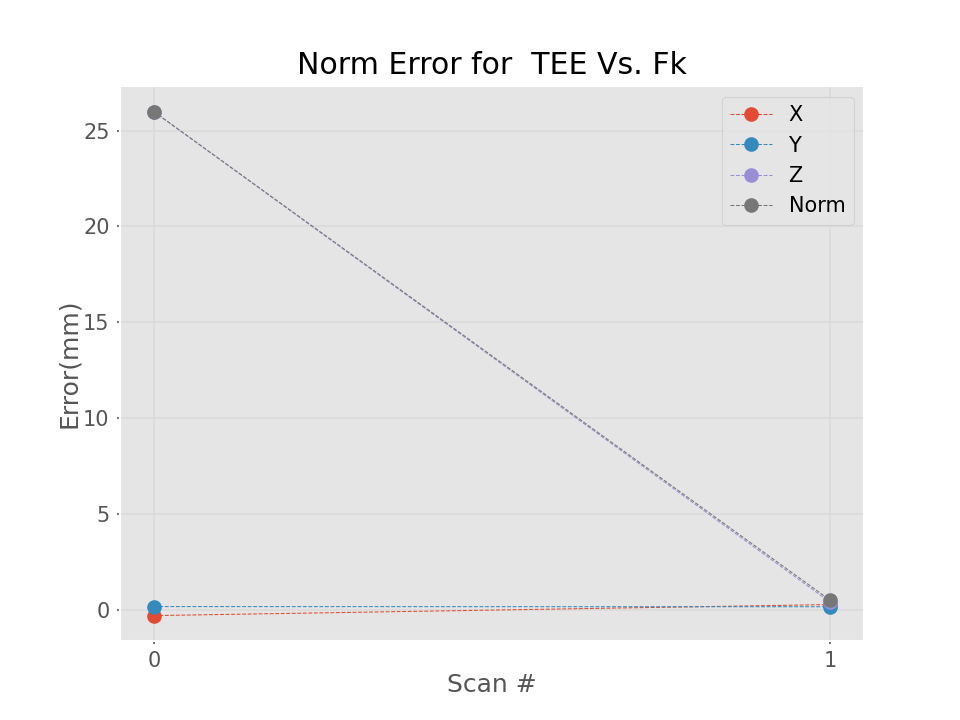

In [31]:
plot6l(x_l,y_l,z_l,x_l2,y_l2,z_l2,False)
plot6l(x_r,y_r,z_r,x_r2,y_r2,z_r2,True)
plot_pe(pe_data)

In [32]:
with open('./test_data/data.pkl', 'rb') as f:
    new_data = pickle.load(f)

### Tfk in 3D

In [33]:
for x in range(len(new_data)):
    n = 'scan'+str(x)
    fk,_,_ = find_fk(new_data[n][0],new_data[n][1],new_data[n][2])
    display_fk(fk,new_data[n][0],mesh_l[x])

Postion Error norm(mm):  1.0489356569735144
Rotional Error norm(Euler Angle):  [-6.30577198e-19  1.02981071e-02 -3.43121867e-03]


IndexError: list index out of range

### Tfk plots

<IPython.core.display.Javascript object>


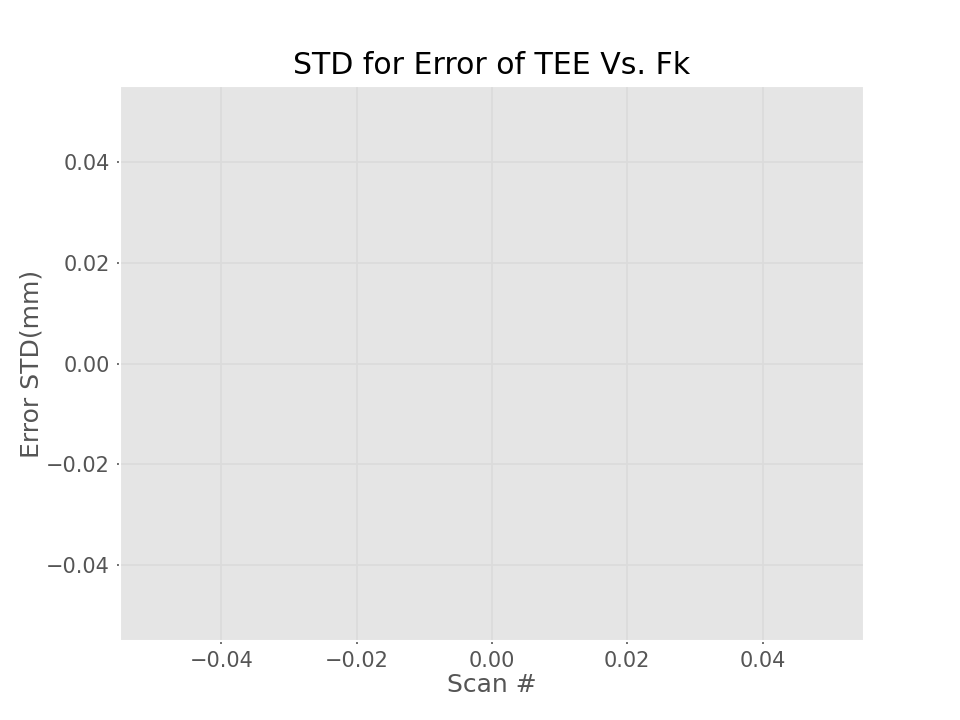

<IPython.core.display.Javascript object>


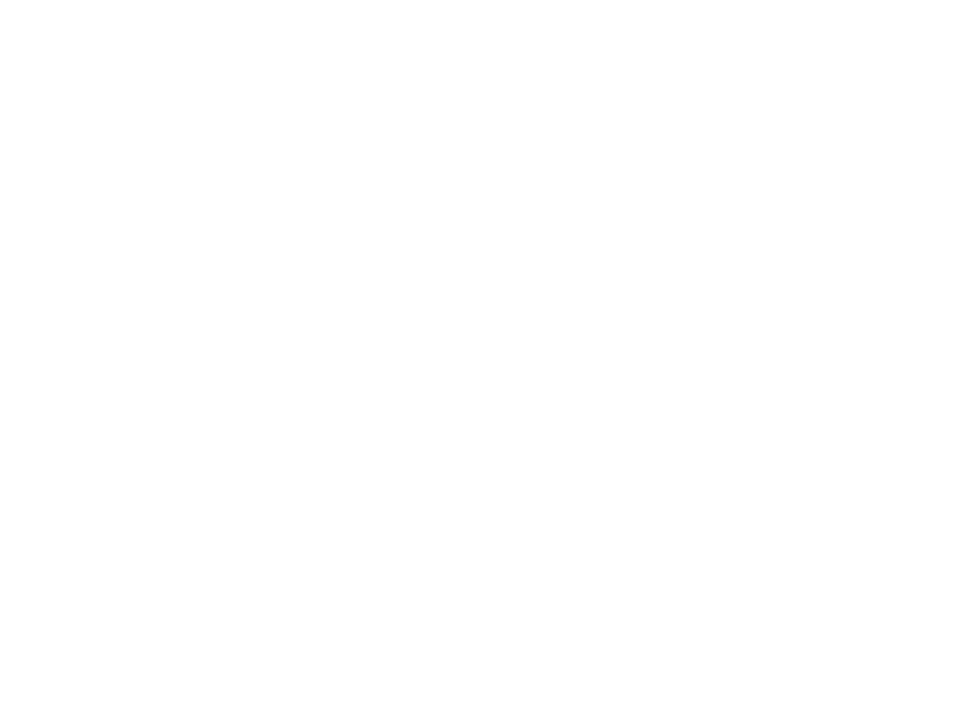

IndexError: list index out of range

In [34]:
plt.plot(P_norm_list)
plt.title("Norm Error for  TEE Vs. Fk")
plt.ylabel("Error(mm)")
plt.xlabel("Scan #")
plt.figure()
plt.plot(P_std)
plt.title("STD for Error of TEE Vs. Fk")
plt.ylabel("Error STD(mm)")
plt.xlabel("Scan #")
plt.figure()
sns.boxplot(data=P_list,  orient='v').set(title='Error for  TEE Vs. Fk',ylabel="Error(mm)",xlabel="Scan#")

# Crane Plots

In [35]:
with open('./test_data/crane_data_postion.pkl', 'rb') as f:
    cpdata = pickle.load(f)

In [36]:
with open('./test_data/crane_data_rotaion.pkl', 'rb') as f:
    codata = pickle.load(f)

In [37]:
# load the marker transform to list
Tee_list = []
Tb_list = []
Tr_list = []
for x in cpdata:
    Tee_list.append(cpdata[x][0].T)
    Tb_list.append(cpdata[x][1].T)
for y in codata:
    Tee_list.append(codata[y][0].T)
    Tb_list.append(codata[y][1].T)

In [38]:
for z in range(len(Tb_list)):
    Tr_list.append(Tb_list[z].inv()*Tee_list[z])

In [39]:
with open('tracked_robot_EE.pkl', 'wb') as f:
    pickle.dump(Tee_list, f)
with open('tracked_robot_base.pkl', 'wb') as f:
    pickle.dump(Tb_list, f)
with open('EE_relative_base.pkl', 'wb') as f:
    pickle.dump(Tr_list, f)

In [40]:
def display_o3d_track(l1,l2,mesh=None):
    v_list = []
    for i in range(len(l1)):
        marker = np.load('./test_data/marker2.npy')
        marker_3d_transformed = create_marker_visualization(marker, [0.8, 0.8, 0.2], l2[i].R, l2[i].t.reshape((3,1)))
        marker_3d_transformed.append(create_coordinate_frame_visualization(l2[i].R, l2[i].t.reshape((3,1))))
        marker = np.load('./test_data/marker1.npy')
        marker_3d_target = create_marker_visualization(marker, [0.2, 0.8, 0.8],l1[i].R, l1[i].t.reshape((3,1)))
        marker_3d_target.append(create_coordinate_frame_visualization(l1[i].R, l1[i].t.reshape((3,1))))
        if i == 0:
            v_list = marker_3d_transformed + marker_3d_target
        else:
            v_list += marker_3d_transformed + marker_3d_target
    if mesh is not None:
        o3d.visualization.draw_geometries(v_list+[mesh])
    else:
        o3d.visualization.draw_geometries(v_list)

In [41]:
convert_mha_to_mesh(output_mesh_file = 'temp_full_mesh.obj', threshold_value = -100)
temp_full_mesh = o3d.io.read_triangle_mesh('temp_full_mesh.obj').paint_uniform_color([0.7, 0.7, 0.7]).compute_vertex_normals()

spacing:  [0.62500392 0.878906   0.878906  ]
image shape in sitk (x,y,z): width 512 then height 512 then depth 256
 origin:  [-149.688 -225.    -225.   ]
numpy version shape: (z,y,x) (256, 512, 512)
locations of different pixels in image [(-225.0, -225.0, -149.688), (224.99987199999998, 224.99987199999998, 10.313003921568622)]
there math https://discourse.itk.org/t/solved-transformindextophysicalpoint-manually/1031/10
perhpas mcubes mirrors?
extreme simple itk pixels: [-960, -978]
extreme simple itk pixels: [-960, -978]
verts shape: (1940099, 3)
verts type: <class 'numpy.ndarray'>


In [42]:
display_o3d_track(Tee_list,Tb_list,temp_full_mesh)

In [43]:
Tfk_list=[]
def add_fk(a,l):
    l.append(SE3(a,check=False))

In [44]:
# scan0
ar = np.array([[-.998, .058, .012, -299],[.058, .997, .054, -1814],[-.009, .055, -.998, 1164],[0, 0, 0, 1]])
add_fk(ar,Tfk_list)

In [45]:
# x+10
ar = np.array([[-.998, .058, .012, -289],
[.058, .997, .054, -1814],
[-.009, .055, -.998, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [46]:
# x-10
ar =np.array([[-.998, .057, .012, -309],
[.057, .997, .054, -1814],
[-.009, .055, -.998, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [47]:
# y+10
ar =np.array([[-.998, .057, .012, -299],
[.058, .997, .054, -1804],
[-.009, .055, -.998, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [48]:
# y-10
ar =np.array([[-.998, .058, .012, -299],
[.058, .997, .054, -1824],
[-.009, .055, -.998, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [49]:
# z+10
ar =np.array([[-.998, .058, .012, -299],
[.058, .997, .054, -1814],
[-.009, .055, -.998, 1174],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [50]:
# z-10
ar =np.array([[-.998, .058, .012, -299],
[.058, .997, .054, -1814],
[-.009, .055, -.998, 1154],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [51]:
# scan7
ar =np.array([[-.998, .058, .012, -299],
[.058, .997, .054, -1814],
[-.009, .055, -.998, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [52]:
# pitch+5deg
ar =np.array([[-.98, .071, .0185, -299],
[.082, .995, .055, -1814],
[-.18, .069, -.981, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [53]:
# pitch-5deg
ar =np.array([[-.986, .043, .0162, -299],
[.0034, .998, .054, -1814],
[.163, .048, -.985, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [54]:
# yaw+5deg
ar =np.array([[-.988, .057, .012, -299],
[.0058, .998, .141, -1814],
[-.004, .0142, -.99, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [55]:
# yaw-5deg
ar =np.array([[-.988, .059, .012, -299],
[.0058, .998, -.033, -1814],
[-.014, -.032, -.99, 1164],
[0, 0, 0, 1]
])
add_fk(ar,Tfk_list)

In [56]:
with open('FK_robot_tip.pkl', 'wb') as f:
    pickle.dump(Tfk_list, f)

In [57]:
display_o3d_track(Tr_list,Tfk_list)

#  (Sequence 8 to 11) plot

In [58]:
def display_o3d_track(l1,l2,mesh=None):
    v_list = []
    for i in range(len(l1)):
        marker = np.load('./test_data/marker2.npy')
        marker_3d_transformed = create_marker_visualization(marker, [0.8, 0.8, 0.2], l2[i].R, l2[i].t.reshape((3,1)))
        marker_3d_transformed.append(create_coordinate_frame_visualization(l2[i].R, l2[i].t.reshape((3,1))))
        marker = np.load('./test_data/marker1.npy')
        marker_3d_target = create_marker_visualization(marker, [0.2, 0.8, 0.8],l1[i].R, l1[i].t.reshape((3,1)))
        marker_3d_target.append(create_coordinate_frame_visualization(l1[i].R, l1[i].t.reshape((3,1))))
        if i == 0:
            v_list = marker_3d_transformed + marker_3d_target
        else:
            v_list += marker_3d_transformed + marker_3d_target
    if mesh is not None:
        o3d.visualization.draw_geometries(v_list+[mesh])
    else:
        o3d.visualization.draw_geometries(v_list)

In [59]:
convert_mha_to_mesh(output_mesh_file = 'temp_full_mesh.obj', threshold_value = -100)
temp_full_mesh = o3d.io.read_triangle_mesh('temp_full_mesh.obj').paint_uniform_color([0.7, 0.7, 0.7]).compute_vertex_normals()

spacing:  [0.62500392 0.878906   0.878906  ]
image shape in sitk (x,y,z): width 512 then height 512 then depth 256
 origin:  [-149.688 -225.    -225.   ]
numpy version shape: (z,y,x) (256, 512, 512)
locations of different pixels in image [(-225.0, -225.0, -149.688), (224.99987199999998, 224.99987199999998, 10.313003921568622)]
there math https://discourse.itk.org/t/solved-transformindextophysicalpoint-manually/1031/10
perhpas mcubes mirrors?
extreme simple itk pixels: [-960, -978]
extreme simple itk pixels: [-960, -978]
verts shape: (1940099, 3)
verts type: <class 'numpy.ndarray'>


In [60]:
with open('./tracked_robot_EE.pkl', 'rb') as f:
    Tee_list = pickle.load(f)
with open('./tracked_robot_base.pkl', 'rb') as f:
    Tb_list = pickle.load(f)

In [62]:
display_o3d_track(Tee_list[7:],Tb_list[7:],temp_full_mesh)